In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler

import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))
#print(sys.path)
import util.items as items

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


import keras
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

Using TensorFlow backend.


ImportError: No module named 'tensorflow'

In [9]:
item = 'Abyssal_whip'

In [10]:
items.getPrices(item)[-10:]

[2663958,
 2643140,
 2626840,
 2614224,
 2606262,
 2593007,
 2593049,
 2587581,
 2581066,
 2581709]

In [11]:
items.getInfo(item)

{'alchable': 'True',
 'buyLimit': '70',
 'destroy': 'Drop',
 'edible': 'False',
 'equipable': 'True',
 'examine': 'A weapon from the abyss.',
 'exchangePrice': '2622266',
 'highAlch': '72000',
 'image': '/w/File:Abyssal_whip.png',
 'lowAlch': '48000',
 'members': 'True',
 'name': 'Abyssal_whip',
 'noteable': 'True',
 'quest': 'No',
 'released': '26 January 2005',
 'seller': 'N/A',
 'stackable': 'False',
 'storeCurrency': 'N/A',
 'storeprice': 'N/A',
 'tradeable': 'True',
 'update': '/w/Update:Slayer_Skill',
 'weight': '0.453'}

1286 1295 1286


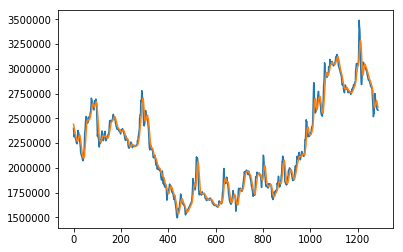

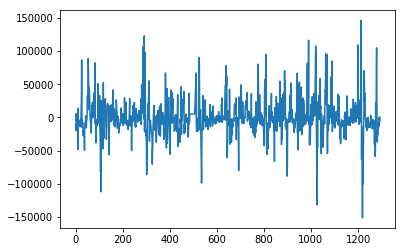

In [12]:
ma = 10
prices = items.getPrices(item)
changes = items.getPriceChanges(item)
movAvg = items.movingAverage(item,ma)
print(len(movAvg),len(prices),len(prices[ma-1:]))
plt.plot(prices[ma-1:])
plt.plot(movAvg)
plt.plot()
plt.show()
plt.plot(changes)
plt.show()

[[-0.39886178]
 [-0.59478149]
 [-0.73148709]
 [ 0.21354183]
 [-0.21807331]]


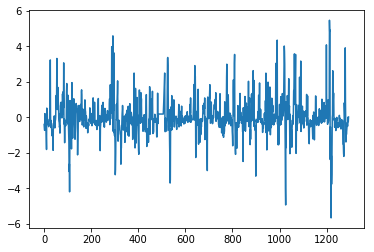

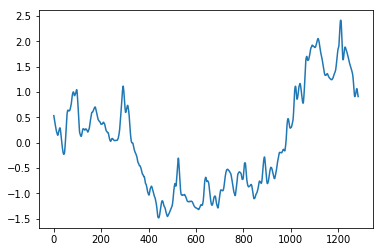

In [13]:
scaler = StandardScaler()
s_changes = scaler.fit_transform(np.array(changes).reshape(-1, 1))
print(s_changes[0:5])
s_movAvg = scaler.fit_transform(np.array(movAvg).reshape(-1, 1))
plt.plot(s_changes)
plt.show()
plt.plot(s_movAvg)
plt.show()

In [14]:
def classify(d):
    if d>=0:
        return 1
    if d<0:
        return 0

In [15]:
x = []
y = []
p = []
c = []
size = 10
for i in range(-1*len(s_changes),-1*size,1):
    x.append([a[0] for a in s_changes[i:i+size]])
    y.append(changes[i+size])
    c.append(classify(changes[i+size]))
    p.append(prices[i+size])
print(x[1],y[0])
print(len(x[0]),len(x[-1]))
print(len(x),len(y),len(p))
#y = keras.utils.to_categorical(y, num_classes=2)

[-0.5947814913458914, -0.7314870851831584, 0.2135418308995593, -0.2180733097526775, -0.23773644311283235, -0.2906209084548107, -0.4258283587979706, -0.5626463133972955, -1.3085345055258355, -1.8100380401781655] -48252
10 10
1284 1284 1284


1027 1027 128 128 129 129 129
10 [-0.39886178 -0.59478149 -0.73148709  0.21354183 -0.21807331 -0.23773644
 -0.29062091 -0.42582836 -0.56264631 -1.30853451]
-48252.0
10 [ 0.40991099  0.06260387 -0.44036035 -0.43998581 -0.19608805 -0.34706346
 -0.09103074 -0.03945715 -0.19593824  0.0195697 ]
-4633.0


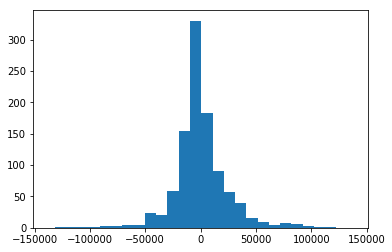

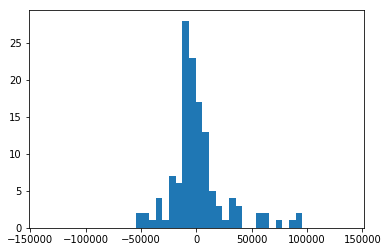

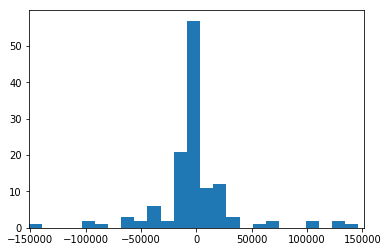

In [16]:
s1 = int(len(y)*.8)
s2  =int(len(y)*.9)

x_train = np.array(x[:s1])
y_train = np.array(y[:s1])
c_train = np.array(c[:s1])

x_val = np.array(x[s1:s2])
y_val = np.array(y[s1:s2])
c_val = np.array(c[s1:s2])

x_test = np.array(x[s2:])
y_test = np.array(y[s2:])
p_test = np.array(p[s2:])
c_test = np.array(c[s2:])

print(len(x_train),len(y_train),len(x_val),len(y_val),len(x_test),len(y_test),len(p_test))
print(len(x_train[0]),x_train[0])
print(y_train[0])
print(len(x_test[0]),x_test[0])
print(y_test[0])

limit = max([abs(max(y)),abs(min(y))])+1
plt.xlim(-1*limit,limit)
plt.hist(y_train,25)
plt.show()
plt.xlim(-1*limit,limit)
plt.hist(y_val,25)
plt.show()
plt.xlim(-1*limit,limit)
plt.hist(y_test,25)
plt.show()

In [17]:
model = Sequential()
model.add(Dense(10, input_dim=size, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
print(model.summary())

NameError: name 'Sequential' is not defined

In [18]:
sgd = SGD(lr=0.2)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(x_train, y_train,
            validation_data=(x_val,y_val),
            epochs=50,
            batch_size=10)

NameError: name 'SGD' is not defined

In [19]:
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

NameError: name 'model' is not defined

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'],label='Test')
plt.plot(history.history['val_mean_squared_error'],label='Valid')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label='Test Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [21]:
y_pred = model.predict(x_test)
print(y_pred[:5])
plt.plot(y_pred,label='Pred')
plt.plot(y_test,label='Actual')
plt.legend()
plt.show()
plt.plot(y_pred[-30:],label='Pred')
plt.plot(y_test[-30:],label='Actual')
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [26]:
import util.trading_systems as ts

bl = int(items.getInfo(item)['buyLimit'])
print(len(x_test),len(y_test),len(p_test))
budgets = [10**5,10**6,10**7,10**8,10**9]
mpBest = [([-100],-1)] * len(budgets)
ppBest = [[-100]] * len(budgets)
bhBest = [[-100]] * len(budgets)
perBest = [[-100]] * len(budgets)
print(c_test[:10])
#yp = model.predict(x_test)
for b in range(len(budgets)):
    print(budgets[b])
    t = 0
    bhBest[b] = ts.buyAndHold(p_test,bl,budgets[b])
    ppBest[b] = ts.perfectProfit(c_test,p_test,bl,budgets[b])
    perBest[b] = ts.persistanceProfit(c_test,p_test,bl,budgets[b])
    #for i in range(10):
        #mp = modelProfit(t,yp,p_test,bl,budgets[b])
        #if mp[-1]>mpBest[b][0][-1] and mp[-1]!=0.0:
         #   mpBest[b] = (mp,t)
        #t += .02

129 129 129
[0 0 0 0 1 0 0 1 0 0]
100000
1000000
10000000
100000000
1000000000


In [27]:
for b in range(len(budgets)):
    print(budgets[b])
    print('\tModel\n\t',mpBest[b][0][-1],mpBest[b][1])
    print('\tPersistance\n\t',perBest[b][-1])
    print('\tPerfect\n\t',ppBest[b][-1])
    print('\tBuy and Hold\n\t',bhBest[b][-1])

100000
	Model
	 -100 -1
	Persistance
	 0.0
	Perfect
	 0.0
	Buy and Hold
	 0.0
1000000
	Model
	 -100 -1
	Persistance
	 0.0
	Perfect
	 0.0
	Buy and Hold
	 0.0
10000000
	Model
	 -100 -1
	Persistance
	 0.2187601
	Perfect
	 0.4585685
	Buy and Hold
	 -0.0612612
100000000
	Model
	 -100 -1
	Persistance
	 0.26075968
	Perfect
	 0.54136135
	Buy and Hold
	 -0.0714714
1000000000
	Model
	 -100 -1
	Persistance
	 0.12302204
	Perfect
	 0.267352607
	Buy and Hold
	 -0.01429428


1 129 128 129
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


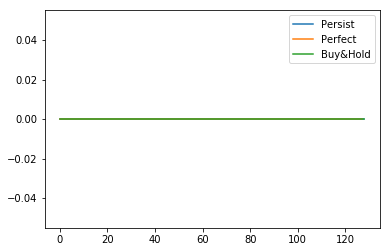

1 129 128 129
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


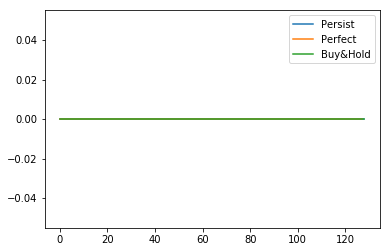

1 129 128 129
[0.0, 0.0, 0.0, 0.0, 0.0, -0.0007959, -0.0007959, -0.0007959, -0.0022518, -0.0022518]


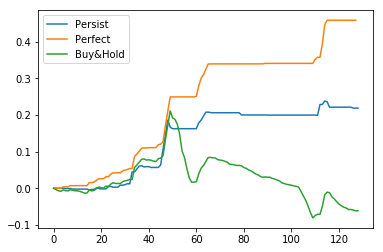

1 129 128 129
[0.0, 0.0, 0.0, 0.0, 0.0, -0.00095508, -0.00095508, -0.00095508, -0.00270216, -0.00270216]


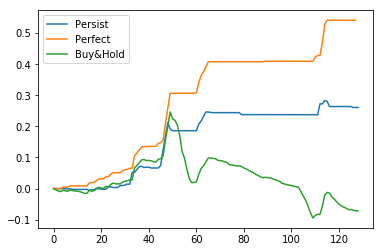

1 129 128 129
[0.0, 0.0, 0.0, 0.0, 0.0, -0.00018571, -0.00018571, -0.00018571, -0.00052542, -0.00052542]


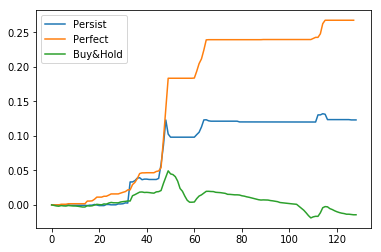

In [28]:
for b in range(len(budgets)):
    print(len(mpBest[b][0]),len(perBest[b]),len(ppBest[b]),len(bhBest[b]))
    #plt.plot(mpBest[b][0],label='Model')
    print(perBest[b][:10])
    plt.plot(perBest[b],label='Persist')
    plt.plot(ppBest[b],label='Perfect')
    plt.plot(bhBest[b],label='Buy&Hold')
    plt.legend()
    plt.show()